In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Reduced image size for ESP32 compatibility
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
ALPHA = 0.35  # Width multiplier

def round_filters(filters):
    """Round number of filters based on width multiplier"""
    filters *= ALPHA
    new_filters = int(filters + 0.5)
    # Make sure it's divisible by 8 for hardware efficiency
    new_filters = max(8, (new_filters // 8) * 8)
    return new_filters

def conv_block(x, filters, kernel, strides):
    filters = round_filters(filters)
    x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    return ReLU()(x)

def inverted_res_block(x, expand, squeeze, strides):
    expand = round_filters(expand)
    squeeze = round_filters(squeeze)

    m = Conv2D(expand, (1,1), strides=1, padding='same')(x)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    m = DepthwiseConv2D((3,3), strides=strides, padding='same')(m)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    m = Conv2D(squeeze, (1,1), strides=1, padding='same')(m)
    m = BatchNormalization()(m)

    if strides == 1 and x.shape[-1] == m.shape[-1]:
        return Add()([x, m])
    return m

def create_pruned_mobilenet():
    inputs = Input(shape=(*IMG_SIZE, 3))

    # Initial conv layer
    x = conv_block(inputs, 32, (3,3), strides=2)

    # Inverted residual blocks (pruned version)
    x = inverted_res_block(x, expand=16, squeeze=16, strides=1)
    x = inverted_res_block(x, expand=64, squeeze=24, strides=2)
    x = inverted_res_block(x, expand=72, squeeze=24, strides=1)
    x = inverted_res_block(x, expand=72, squeeze=40, strides=2)
    x = inverted_res_block(x, expand=120, squeeze=40, strides=1)
    x = inverted_res_block(x, expand=120, squeeze=40, strides=1)
    x = inverted_res_block(x, expand=240, squeeze=80, strides=2)
    x = inverted_res_block(x, expand=200, squeeze=80, strides=1)
    x = inverted_res_block(x, expand=184, squeeze=80, strides=1)
    x = inverted_res_block(x, expand=184, squeeze=80, strides=1)

    # Final layers
    x = conv_block(x, 1280, (1,1), strides=1)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs)

# Create the pruned model
model = create_pruned_mobilenet()
model.summary()

# Data generators (same as before but with new IMG_SIZE)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
# Unzip dataset (comment out if already unzipped)
!unzip '/content/Dataset.zip' -d '/dataset'



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 48, 48, 8) │        224 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48, 8) │         32 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 48, 48, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 48, 48, 8) │         72 │ re_lu_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48, 8) │         32 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 48, 48, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_10 │ (None, 48, 48, 8) │         80 │ re_lu_24[0][0]    │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48, 8) │         32 │ depthwise_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 48, 48, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 48, 48, 8) │         72 │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48, 8) │         32 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 48, 48, 8) │          0 │ re_lu_23[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 48, 48,    │        144 │ add_7[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_11 │ (None, 24, 24,    │        160 │ re_lu_26[0][0]    │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat

 Total params: 36,681 (143.29 KB)

 Trainable params: 33,785 (131.97 KB)

 Non-trainable params: 2,896 (11.31 KB)

Streaming output truncated to the last 5000 lines.
  inflating: /dataset/Dataset/test/fire/fire_image_1320.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1321.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1330.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1342.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1344.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1345.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1347.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1358.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1359.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1377.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1392.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1398.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1401.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1405.jpg  
  inflating: /dataset/Dataset/test/fire/fire_image_1406.jpg  
  inflating: /datas

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/dataset/Dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    '/dataset/Dataset/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Quantize the model for ESP32
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save the quantized model
with open('pruned_fire_detection.tflite', 'wb') as f:
    f.write(quantized_model)

Found 4014 images belonging to 2 classes.
Found 492 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 334ms/step - accuracy: 0.5930 - loss: 0.6815 - val_accuracy: 0.4573 - val_loss: 0.8706
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.8021 - loss: 0.4394 - val_accuracy: 0.4573 - val_loss: 1.0767
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step - accuracy: 0.8200 - loss: 0.4127 - val_accuracy: 0.4573 - val_loss: 1.0236
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.8263 - loss: 0.3964 - val_accuracy: 0.5142 - val_loss: 0.6972
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.8410 - loss: 0.3844 - val_accuracy: 0.8232 - val_loss: 0.4162
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.8448 - loss: 0.3757 - val_accuracy: 0.8232 - val_loss: 0.3847
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 331ms/step - accuracy: 0.8532 - loss: 0.3723 - val_accuracy: 0.8435 - val_loss: 0.3701
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.8411 - loss: 0

In [ ]:
# Save model
model.save('fire_detection_model.keras')

In [ ]:
# Plot training and validation accuracy/loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.close()

In [ ]:
# Evaluate model on test set
test_generator = val_test_datagen.flow_from_directory(
    '/dataset/Dataset/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

Found 524 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step


In [ ]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,roc_curve,auc,precision_recall_curve
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Test Loss: 0.3222
Test Accuracy: 0.8721
Precision: 0.8469
Recall: 0.9286
F1-Score: 0.8859


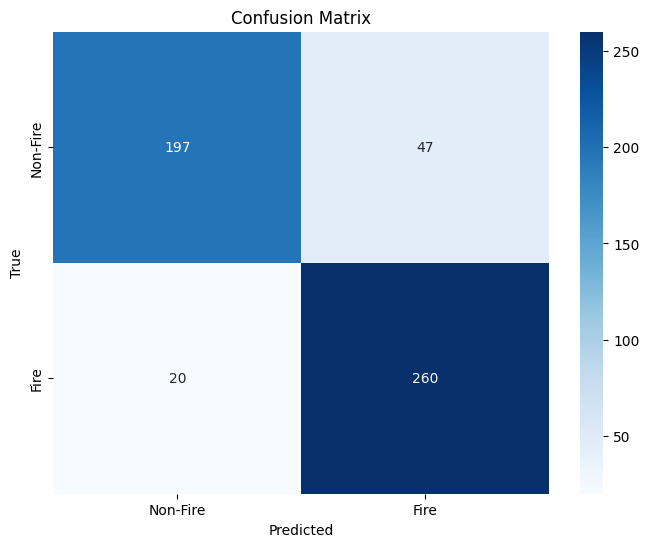

In [ ]:
# Confusion Matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fire', 'Fire'], yticklabels=['Non-Fire', 'Fire'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

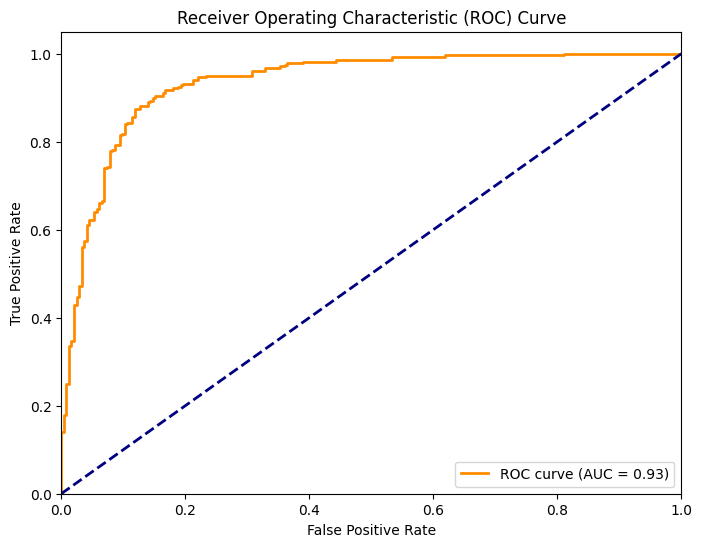

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

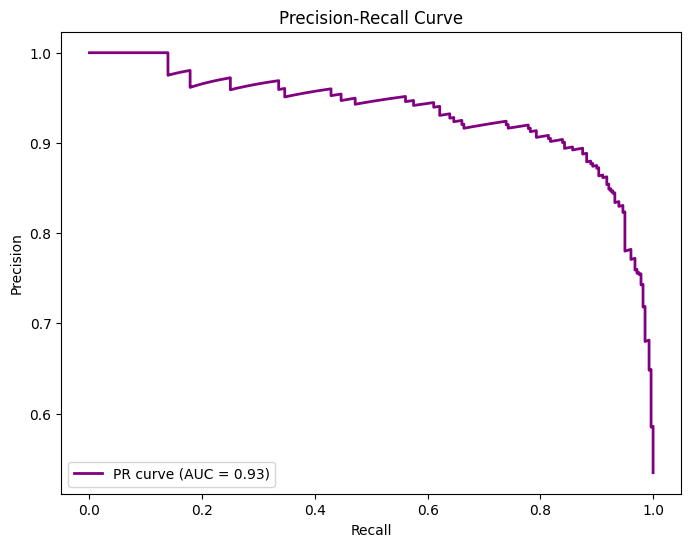

In [ ]:
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, predictions)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

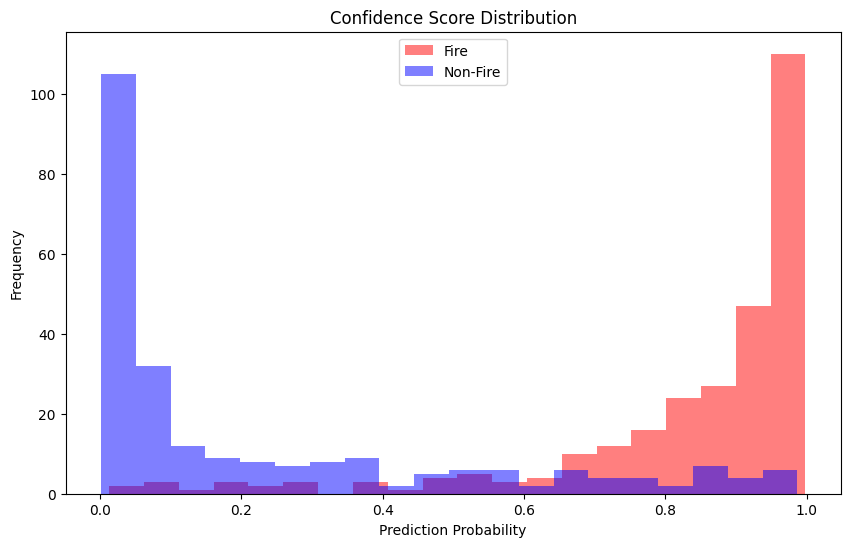

In [ ]:
# Confidence Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(predictions[y_true == 1], bins=20, alpha=0.5, color='red', label='Fire')
plt.hist(predictions[y_true == 0], bins=20, alpha=0.5, color='blue', label='Non-Fire')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.legend()
plt.show()